In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datasets import *
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
from random import randint
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.layers import Input, Reshape, Dense, Conv2D, Dropout, \
    MaxPooling2D, Flatten, UpSampling2D, Multiply, Activation, AveragePooling2D, \
    Add, Subtract, Lambda
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.ndimage import gaussian_filter as blur
from keras.optimizers import Adam
from keras.utils import multi_gpu_model as mgpu
from keras.utils import np_utils
import os, sys

Using TensorFlow backend.


In [3]:
from models.gap import gap

model = gap(imsize=256)
model.load()

 [!] Conv Spec:
 [!] 256 => 128: [64, 128]
 [!] 128 => 64: [256, 256, 256, 256]
 [!] 64 => 32: [256, 256, 256, 256]
 [!] 32 => 16: [512, 512, 512, 512]
 [!] 16 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [1024, 1024, 2048, 2048]


In [4]:
from utils import *

(5752, 4016) (5752, 4016)
Collected 22 15 16


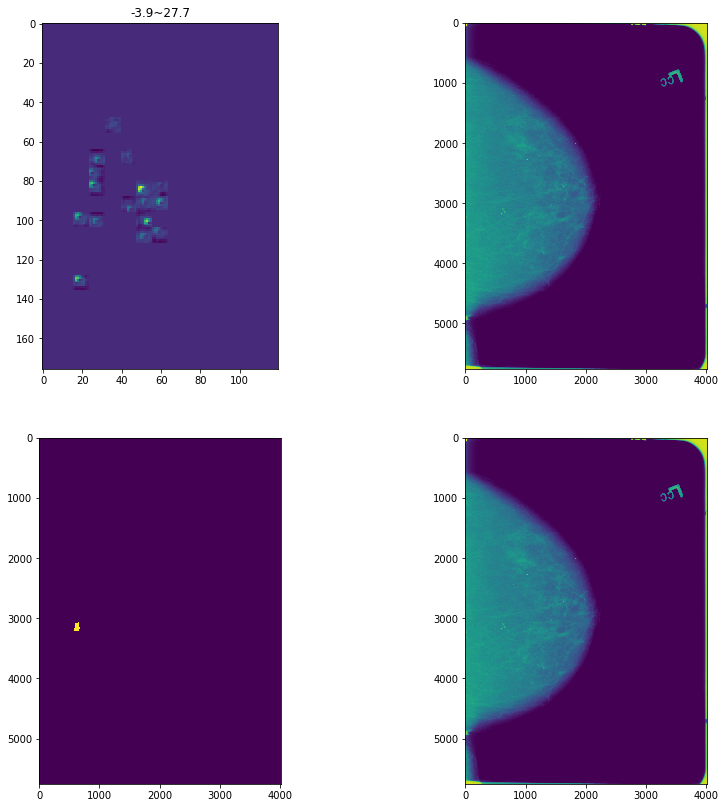

In [5]:
def naive_sliding(casename):
    rawimg, rawmask = plot_raw(casename, noplot=True)
    print(rawimg.shape, rawmask.shape)
    patchwork = []
    size = 256
    __detected = 0
    for yy in range(rawimg.shape[0] // size):
        patches = []
        for xx in range(rawimg.shape[1] // size):
            y0, x0 = yy * size, xx * size

            patch = rawimg[y0:y0+size, x0:x0+size].astype(np.float32) / 255**2
            patches.append(patch)
        patches = np.array(patches).reshape((len(patches), 256, 256, 1))

        ypreds, fmaps = model.saliency(patches)
        weights = model.core.layers[-2].get_weights()[0][:, 1]

        row = []
        for ii in range(len(fmaps)):
            A = np.zeros((8, 8))
            if np.argmax(ypreds[ii]) == 1:
                __detected += 1
                for jj in range(2048):
                    A += fmaps[ii, :, :, jj] * weights[jj]
            row.append(A)
        patchwork.append(row)

    print('Collected', len(patchwork), len(patchwork[0]), __detected)
    
    fsize = len(fmaps[0])
    canvas = np.zeros((fsize * len(patchwork), fsize * len(patchwork[0])))

    for yy, row in enumerate(patchwork):
        for xx, fmap in enumerate(row):
            canvas[yy*fsize:(yy+1)*fsize, xx*fsize:(xx+1)*fsize] = fmap

    plt.figure(figsize=(14, 14))
    plt.subplot(2, 2, 1)
    plt.gca().set_title('%.1f~%.1f' % (np.min(canvas), np.max(canvas)))
    plt.imshow(canvas)
    plt.subplot(2, 2, 2)
    plt.imshow(rawimg)

    plt.subplot(2, 2, 3)
    plt.imshow(rawmask)
    plt.subplot(2, 2, 4)
    plt.imshow(rawimg)
    plt.show()
    plt.close()
    
naive_sliding('01352_LEFT_CC')

(5266, 3916) (5266, 3916)
Collected 20 15 49


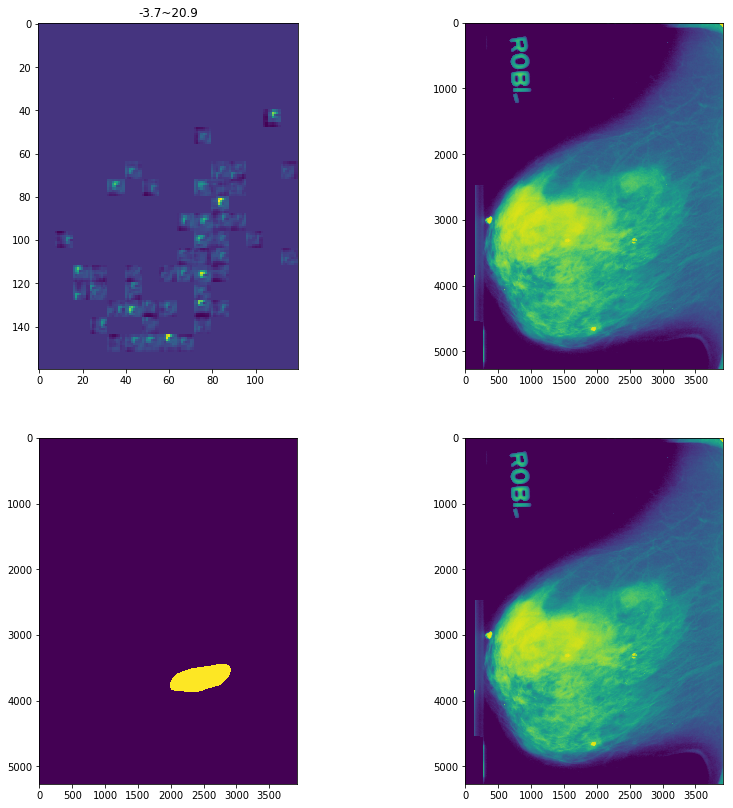

In [6]:
naive_sliding('02559_RIGHT_MLO')